## 1. Load Libraries

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator
from ta.volume import OnBalanceVolumeIndicator
from ta.volatility import AverageTrueRange

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [298]:
pd.read_csv("data/AAPL.csv").columns

Index(['Price', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

## 2. Load and Merge Data (AAPL + SPY + VIX)

In [299]:
col_names = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
aapl = pd.read_csv('data/AAPL.csv', skiprows=2, names=col_names, header=0, index_col='Date', parse_dates=True)
spy = pd.read_csv('data/SPY.csv', skiprows=2, names=col_names, header=0, index_col='Date', parse_dates=True)
vix = pd.read_csv('data/VIX.csv', skiprows=2, names=col_names, header=0, index_col='Date', parse_dates=True)

df = aapl[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
df = df.rename(columns={'Open':'AAPL_Open', 'High':'AAPL_High', 'Low':'AAPL_Low', 'Close':'AAPL_Close', 'Volume':'AAPL_Volume'})
df['SPY_Close'] = spy['Close']
df['VIX_Close'] = vix['Close']
df = df.dropna()
df.head()

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume,SPY_Close,VIX_Close
Date,,,,,,,
2015-01-02,24.746,24.757,23.849,24.289,212818400,171.568,17.79
2015-01-05,24.058,24.138,23.418,23.604,257142000,168.470,19.92
2015-01-06,23.669,23.866,23.244,23.607,263188400,166.883,21.12
2015-01-07,23.815,24.038,23.704,23.938,160423600,168.962,19.31
2015-01-08,24.266,24.915,24.149,24.857,237458000,171.961,17.01


In [300]:
# 2.1 view data
pd.set_option('display.precision', 3)
df.describe()

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume,SPY_Close,VIX_Close
count,2515.000,2515.000,2515.000,2515.000,2.515e+03,2515.000,2515.000
mean,93.907,94.907,92.979,93.995,1.171e+08,311.986,18.269
std,65.436,66.112,64.829,65.518,6.839e+07,115.040,7.284
min,20.570,20.951,20.449,20.647,2.323e+07,155.870,9.140
25%,35.308,35.682,34.918,35.277,7.109e+07,213.382,13.345
50%,64.267,64.859,63.699,64.509,1.004e+08,274.708,16.330
75%,150.318,152.267,148.516,150.536,1.426e+08,401.517,21.325
max,257.569,259.474,257.010,258.397,6.488e+08,602.174,82.690


## 3. Data Exploration

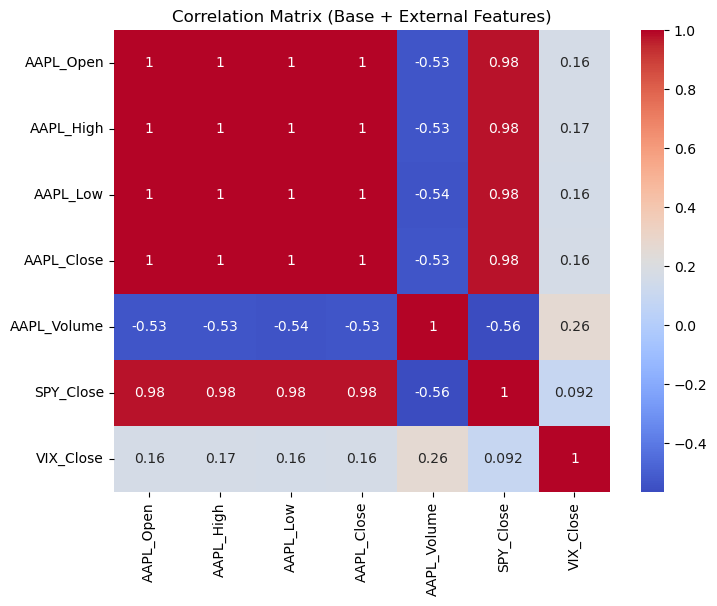

In [301]:
import matplotlib.dates as mdates

# Correlation matrix 
plt.figure(figsize=(8,6))
sns.heatmap(df[['AAPL_Open', 'AAPL_High', 'AAPL_Low', 'AAPL_Close', 'AAPL_Volume', 'SPY_Close', 'VIX_Close']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Base + External Features)')
plt.show()

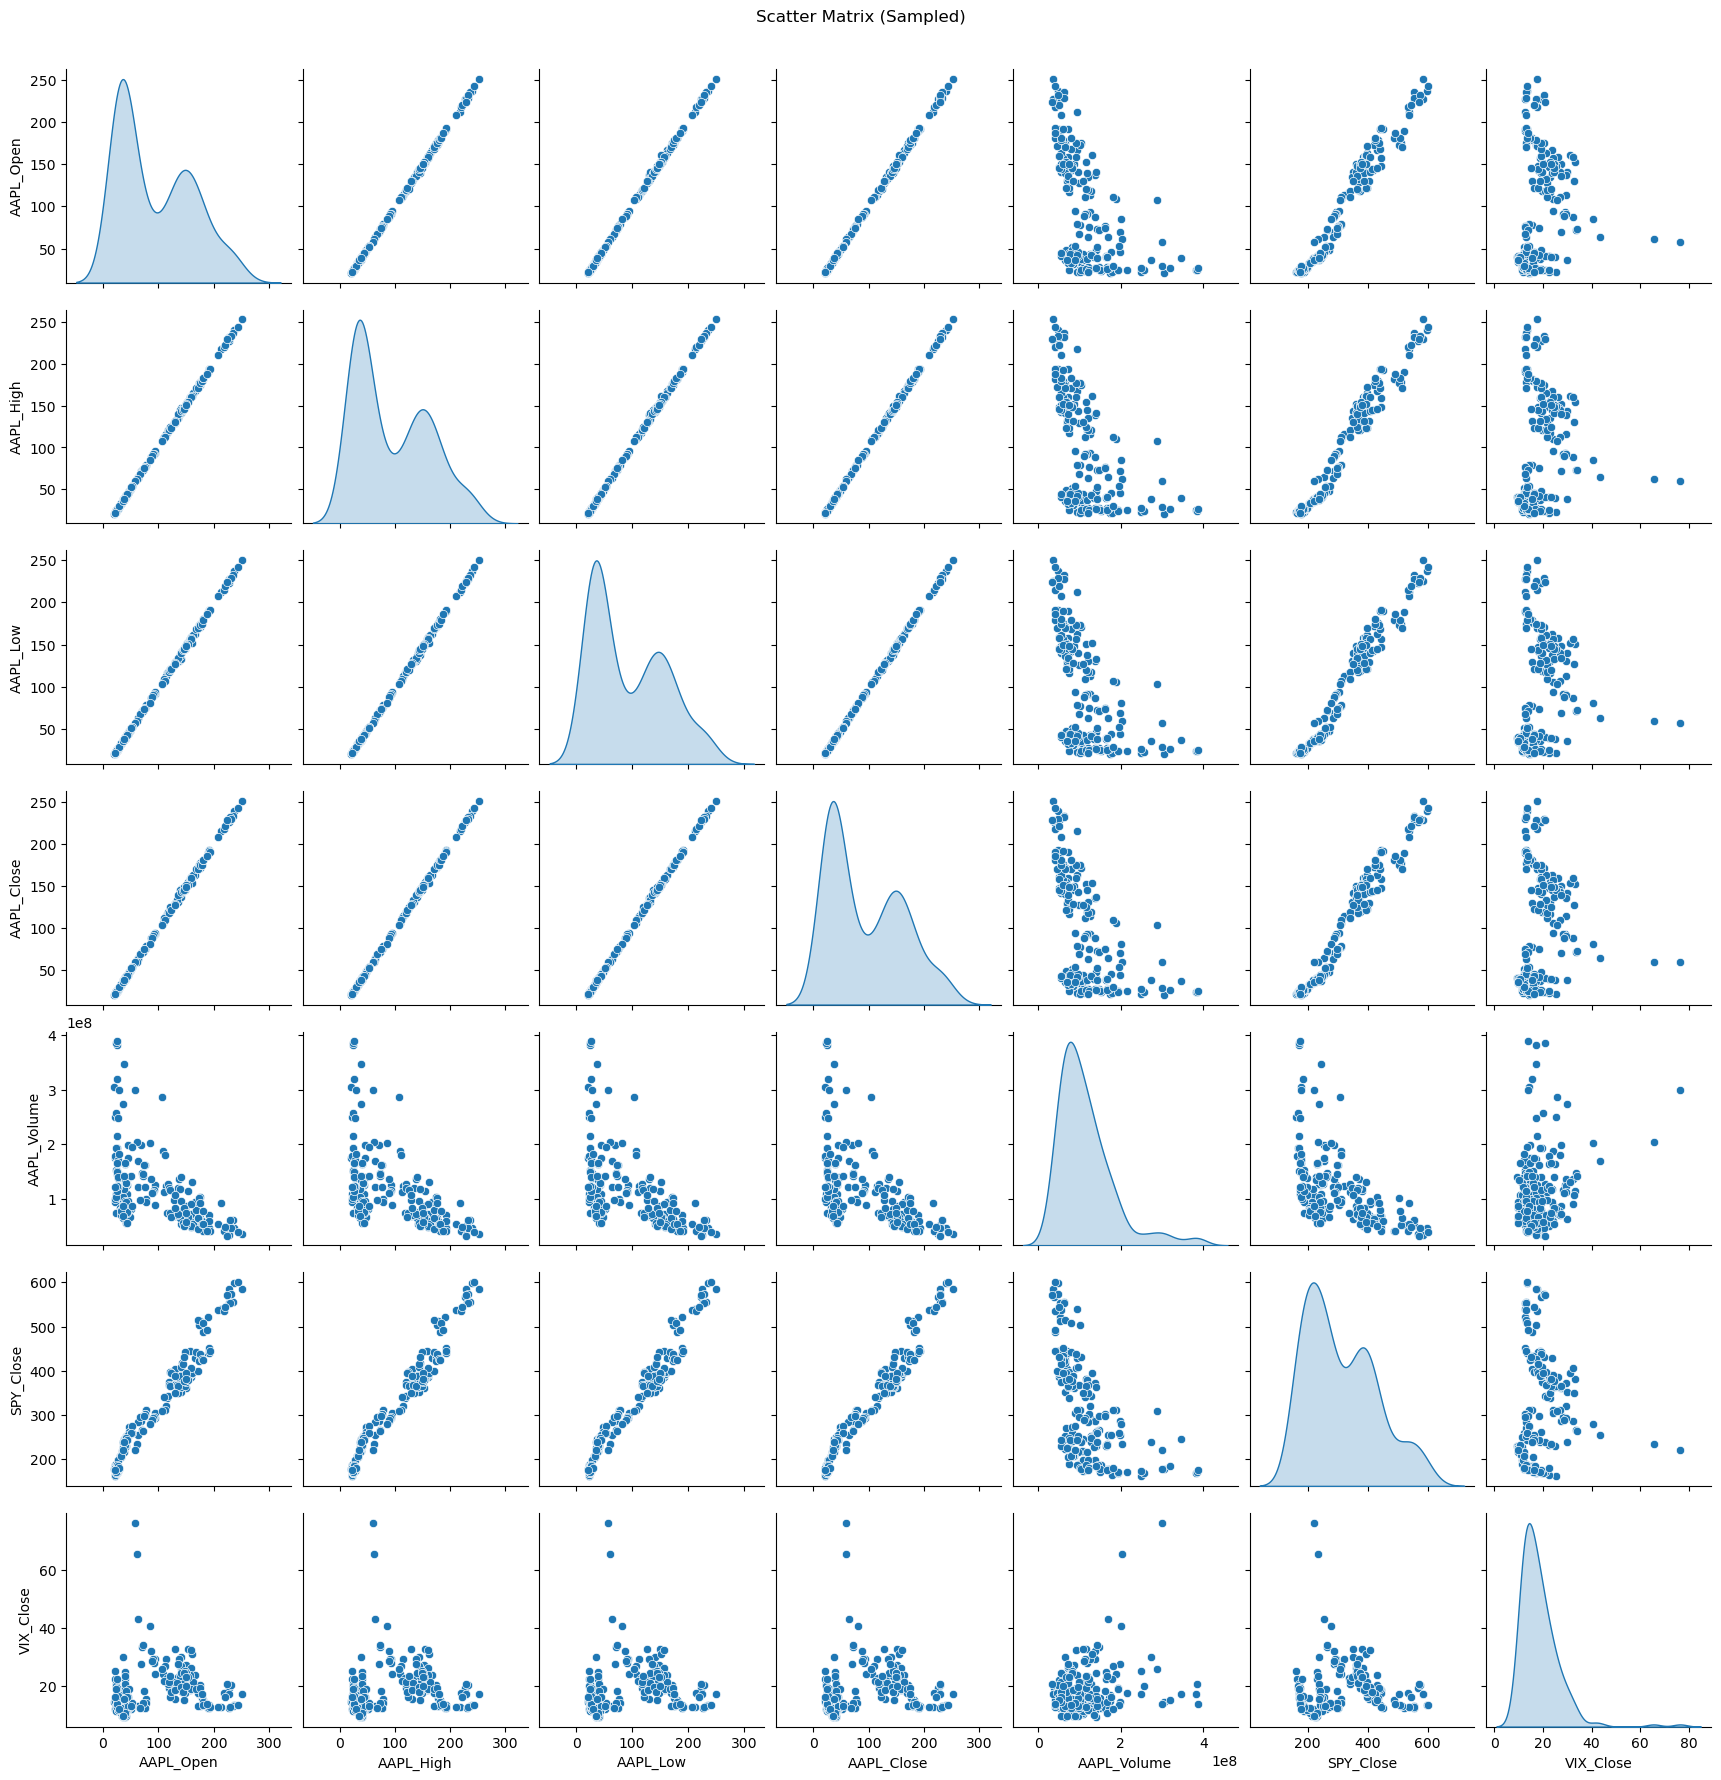

In [302]:
# Scatter matrix 
sns.pairplot(df[['AAPL_Open', 'AAPL_High', 'AAPL_Low', 'AAPL_Close', 'AAPL_Volume', 'SPY_Close', 'VIX_Close']].sample(200), diag_kind='kde')
plt.suptitle('Scatter Matrix (Sampled)', y=1.02)
plt.show()

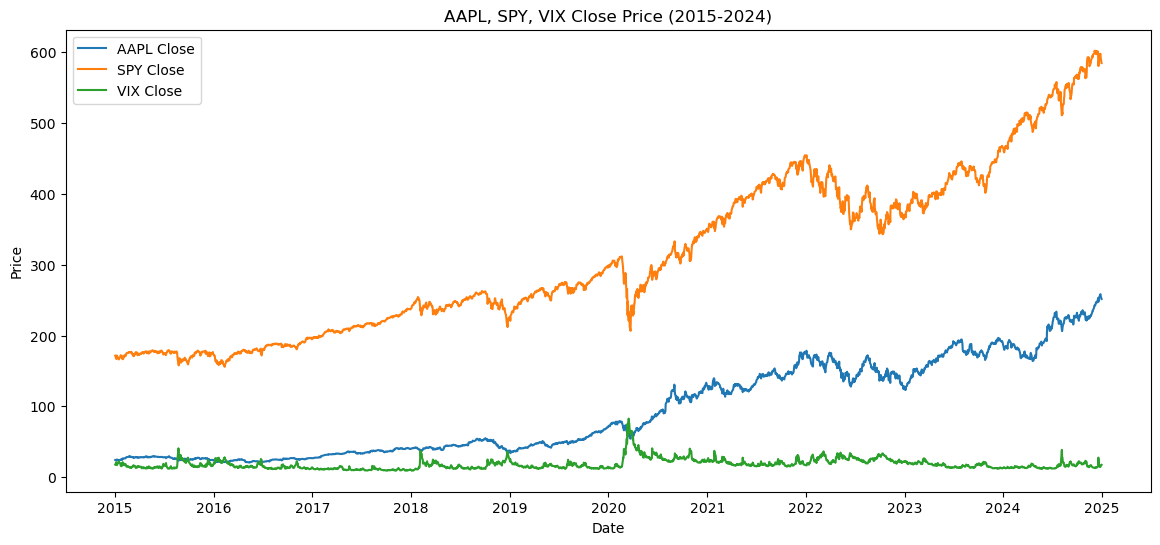

In [303]:
# Time series plot
plt.figure(figsize=(14,6))
plt.plot(df.index, df['AAPL_Close'], label='AAPL Close')
plt.plot(df.index, df['SPY_Close'], label='SPY Close')
plt.plot(df.index, df['VIX_Close'], label='VIX Close')
plt.title('AAPL, SPY, VIX Close Price (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

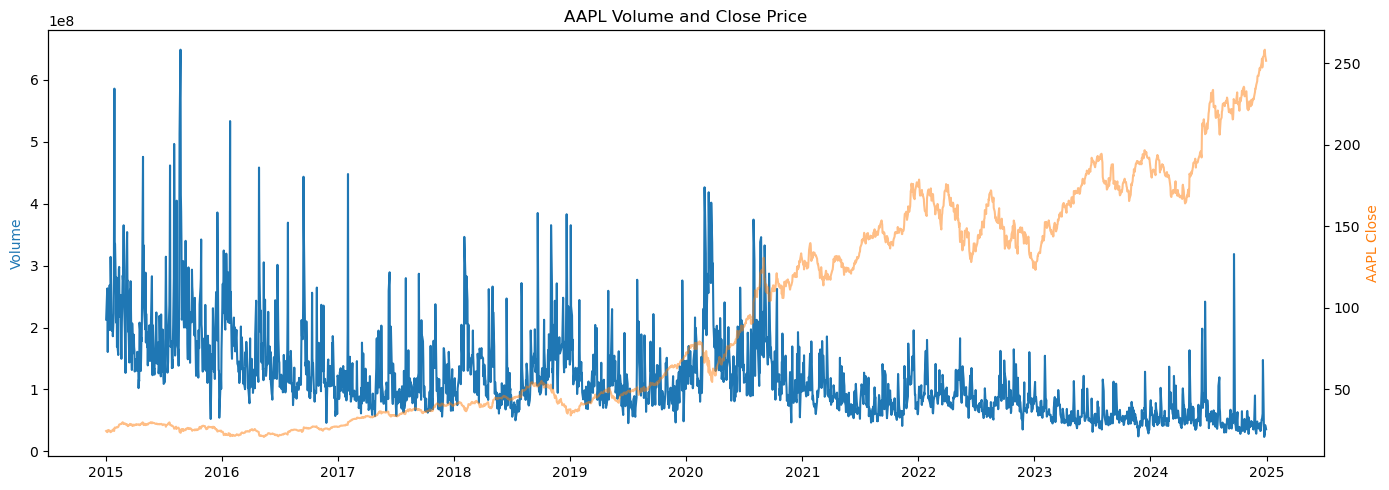

In [304]:

fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(df.index, df['AAPL_Volume'], color='tab:blue', label='AAPL Volume')
ax1.set_ylabel('Volume', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(df.index, df['AAPL_Close'], color='tab:orange', label='AAPL Close', alpha=0.5)
ax2.set_ylabel('AAPL Close', color='tab:orange')
plt.title('AAPL Volume and Close Price')
fig.tight_layout()
plt.show()

## 4. Construct Indicators （total 13 features）

In [305]:
# Technical indicators
df['RSI'] = RSIIndicator(close=df['AAPL_Close'], window=14).rsi()
macd = MACD(close=df['AAPL_Close'])
df['MACD'] = macd.macd()
df['OBV'] = OnBalanceVolumeIndicator(close=df['AAPL_Close'], volume=df['AAPL_Volume']).on_balance_volume()
df['ATR'] = AverageTrueRange(high=df['AAPL_High'], low=df['AAPL_Low'], close=df['AAPL_Close']).average_true_range()
df['SMA_5'] = SMAIndicator(close=df['AAPL_Close'], window=5).sma_indicator()

# PVT
df['PVT'] = (df['AAPL_Volume'] * (df['AAPL_Close'].pct_change())).cumsum()

# Rydex Ratio
rydex = pd.read_csv('indicators/RydexRatio/rydex_ratio_assets_output.csv', index_col=0, parse_dates=True)
rydex = rydex.rename(columns={'rydex_ratio': 'Rydex_Ratio'})
df = df.join(rydex['Rydex_Ratio'], how='inner')

# DIX_proxy
dix = pd.read_csv('indicators/DIX_proxy/DIX_AAPL_out.csv')
dix['DATE'] = pd.to_datetime(dix['DATE'])
dix = dix.set_index('DATE')
dix = dix[['DIX_proxy']]
dix = dix.rename(columns={'DIX_proxy': 'DIX_Proxy'})

# Merge to main df
df = df.join(dix['DIX_Proxy'], how='inner')

feature_cols = [
    'AAPL_Open', 'AAPL_High', 'AAPL_Low', 'AAPL_Close', 'AAPL_Volume',
    'SPY_Close', 'VIX_Close', 'RSI', 'MACD', 'OBV', 'ATR', 'SMA_5', 'PVT', 'Rydex_Ratio', 'DIX_Proxy'
]
df = df[feature_cols]
df = df.dropna()
df.head()

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume,SPY_Close,VIX_Close,RSI,MACD,OBV,ATR,SMA_5,PVT,Rydex_Ratio,DIX_Proxy
2015-02-09,26.441,26.729,26.414,26.702,155559200,170.900,18.55,66.460,0.634,2264114000,0.641,26.580,3.704e+07,1.181,0.493
2015-02-10,26.802,27.244,26.800,27.215,248034000,172.721,17.23,70.230,0.682,2512148000,0.634,26.751,4.181e+07,1.129,0.505
2015-02-11,27.382,27.862,27.322,27.853,294247200,172.821,16.96,74.124,0.762,2806395200,0.635,27.009,4.871e+07,1.125,0.537
2015-02-12,28.116,28.433,28.007,28.205,297898000,174.483,15.34,75.992,0.844,3104293200,0.631,27.300,5.248e+07,1.110,0.511
2015-02-13,28.388,28.388,28.024,28.343,217088800,175.201,14.69,76.703,0.910,3321382000,0.612,27.664,5.354e+07,1.149,0.519


In [306]:
pd.read_csv('indicators/RydexRatio/rydex_ratio_assets_output.csv').head()

,as_of_date,rydex_ratio
0,2015-01-02,1.162
1,2015-01-05,1.195
2,2015-01-06,1.160
3,2015-01-07,1.110
4,2015-01-08,1.049


## 5.Data Processing

In [307]:
# Replace inf/-inf with NaN, then drop
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# Change target to log return
df['Target'] = np.log(df['AAPL_Close'] / df['AAPL_Close'].shift(1))
df = df.dropna()

X = df[feature_cols]
y = df['Target']

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')
print(f'Target range: {y.min():.4f} to {y.max():.4f}')

Train shape: (1975, 15), Test shape: (494, 15)
Target range: -0.1377 to 0.1132


## 6. Feature Tuning

In [308]:
# feature selection

selector = SelectKBest(score_func=f_regression, k=5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_features = X_train.columns[selector.get_support()]
print('Selected features:', list(selected_features))

Selected features: ['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy']


In [309]:
# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

## 7.1 Ridge

In [310]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
val_scores_ridge = []
ridge_coefs = []
selected_features_list = []

# Stronger regularization 
alpha_values = [0.1, 1, 10, 100, 1000]

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    selector = SelectKBest(score_func=f_regression, k=5)
    X_train_sel = selector.fit_transform(X_train_fold, y_train_fold)
    X_val_sel = selector.transform(X_val_fold)
    selected_features = X.columns[selector.get_support()]
    selected_features_list.append(selected_features)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_val_scaled = scaler.transform(X_val_sel)

    # Test different alpha values for regularization
    best_alpha = 1
    best_mse = float('inf')
    
    for alpha in alpha_values:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_scaled, y_train_fold)
        y_val_pred = ridge.predict(X_val_scaled)
        mse = mean_squared_error(y_val_fold, y_val_pred)
        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha
    
    # Use best alpha
    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train_scaled, y_train_fold)
    y_val_pred = ridge.predict(X_val_scaled)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    r2 = r2_score(y_val_fold, y_val_pred)
    val_scores_ridge.append((mse, r2))
    ridge_coefs.append(ridge.coef_)
    print(f"Ridge Fold {fold+1}: MSE={mse:.6f}, R2={r2:.4f}, Alpha={best_alpha}, Features={list(selected_features)}")

val_mse_ridge = np.mean([s[0] for s in val_scores_ridge])
val_r2_ridge = np.mean([s[1] for s in val_scores_ridge])
print(f"\nRidge Average Validation MSE: {val_mse_ridge:.6f}, R2: {val_r2_ridge:.4f}")

Ridge Fold 1: MSE=0.000142, R2=0.0839, Alpha=1000, Features=['AAPL_Volume', 'SPY_Close', 'VIX_Close', 'RSI', 'DIX_Proxy']
Ridge Fold 2: MSE=0.000267, R2=0.1275, Alpha=0.1, Features=['AAPL_Close', 'AAPL_Volume', 'VIX_Close', 'RSI', 'DIX_Proxy']
Ridge Fold 3: MSE=0.000596, R2=0.0620, Alpha=1000, Features=['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy']
Ridge Fold 4: MSE=0.000321, R2=0.1798, Alpha=100, Features=['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy']
Ridge Fold 5: MSE=0.000129, R2=0.2712, Alpha=0.1, Features=['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy']

Ridge Average Validation MSE: 0.000291, R2: 0.1449


In [311]:
# feature selection
final_selector = SelectKBest(score_func=f_regression, k=5)
X_train_selected = final_selector.fit_transform(X_train, y_train)
X_test_selected = final_selector.transform(X_test)
selected_features = X_train.columns[final_selector.get_support()]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

ridge = Ridge()
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

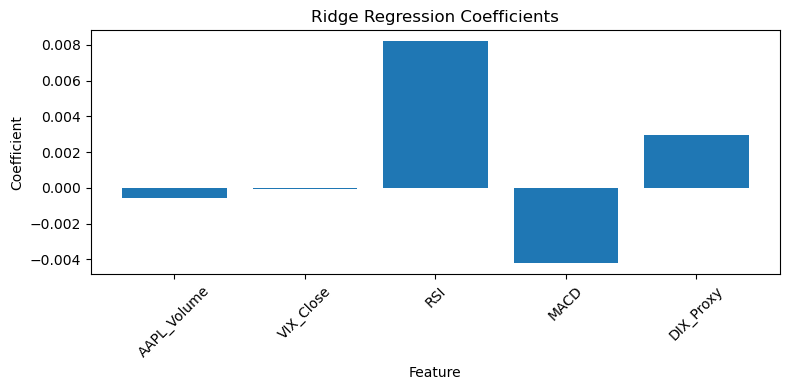

In [312]:
plt.figure(figsize=(8,4))
plt.bar(selected_features, ridge.coef_)
plt.title('Ridge Regression Coefficients')
plt.ylabel('Coefficient')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

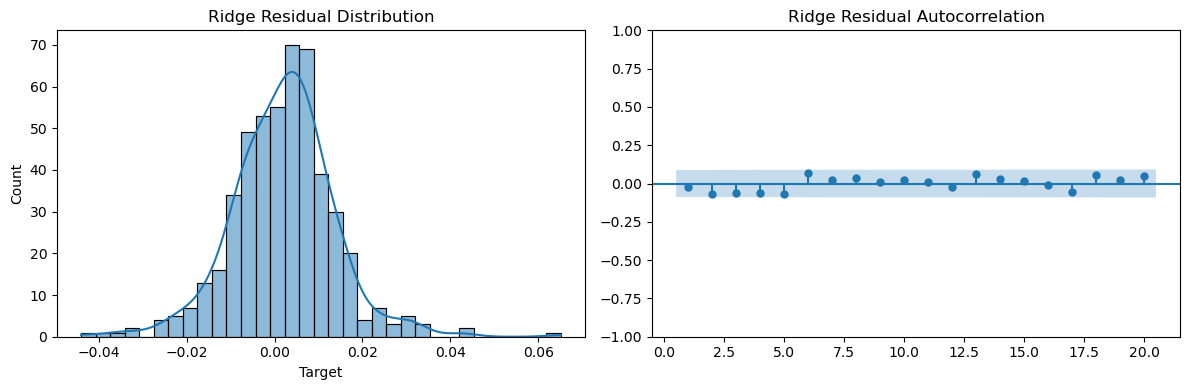

In [313]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

residuals_ridge = y_test - y_pred_ridge

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(residuals_ridge, kde=True, ax=axes[0])
axes[0].set_title('Ridge Residual Distribution')
plot_acf(residuals_ridge, lags=20, zero=False, ax=axes[1])
axes[1].set_title('Ridge Residual Autocorrelation')
plt.tight_layout()
plt.show()

y_train length: 1975
y_train_pred_ridge length: 1975
y_test length: 494
y_pred_ridge length: 494


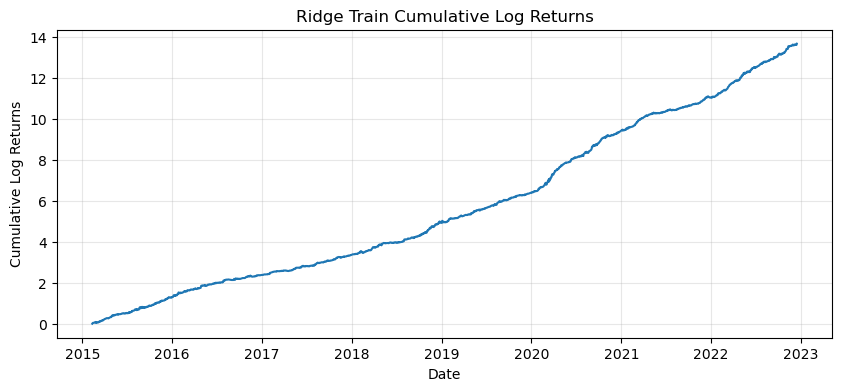

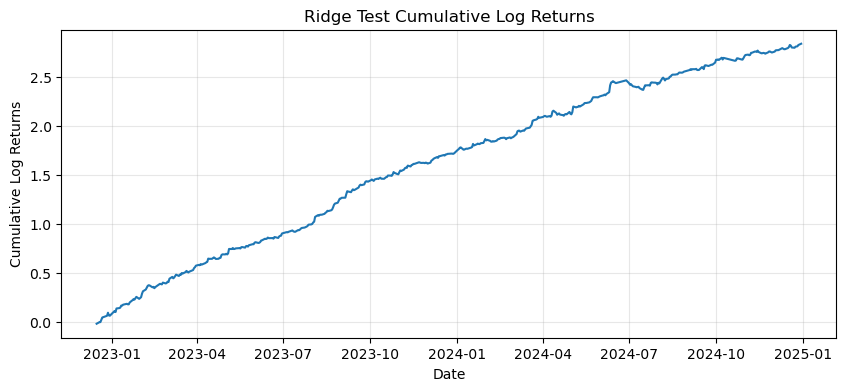

2022-12-16   -0.015
2022-12-19    0.001
2022-12-20    0.002
2022-12-21    0.025
2022-12-22    0.049
              ...  
2024-12-23    2.801
2024-12-24    2.813
2024-12-26    2.816
2024-12-27    2.829
2024-12-30    2.843
Length: 494, dtype: float64

In [314]:
def plot_cumret_log_ridge(y_true, y_pred, title):
   
    if len(y_true) != len(y_pred):
        print(f"Warning: y_true length {len(y_true)}, y_pred length {len(y_pred)}")
        # Use the shorter length
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true.iloc[:min_len]
        y_pred = y_pred[:min_len]
    
    # For log returns, cumulative returns = sum of returns
    positions = np.where(y_pred > 0, 1, -1)  # Simple directional strategy
    returns = positions * y_true.values  # Convert to numpy array
    returns = pd.Series(returns, index=y_true.index).fillna(0)
    
    # For log returns: cumulative return = sum of returns
    cumret = returns.cumsum()
    
    plt.figure(figsize=(10,4))
    plt.plot(cumret)
    plt.title(title)
    plt.ylabel('Cumulative Log Returns')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return cumret

# Ridge model cumulative returns
y_train_pred_ridge = ridge.predict(X_train_scaled)
y_pred_ridge = ridge.predict(X_test_scaled)

print(f"y_train length: {len(y_train)}")
print(f"y_train_pred_ridge length: {len(y_train_pred_ridge)}")
print(f"y_test length: {len(y_test)}")
print(f"y_pred_ridge length: {len(y_pred_ridge)}")

# Train cumulative returns
plot_cumret_log_ridge(y_train, y_train_pred_ridge, 'Ridge Train Cumulative Log Returns')

# Test cumulative returns  
plot_cumret_log_ridge(y_test, y_pred_ridge, 'Ridge Test Cumulative Log Returns')

## 7.2 Linear Regression 

In [315]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
val_scores_lr = []
selected_features_list_lr = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    selector = SelectKBest(score_func=f_regression, k=5)
    X_train_sel = selector.fit_transform(X_train_fold, y_train_fold)
    X_val_sel = selector.transform(X_val_fold)
    selected_features = X.columns[selector.get_support()]
    selected_features_list_lr.append(selected_features)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_val_scaled = scaler.transform(X_val_sel)

    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train_fold)
    y_val_pred = lr.predict(X_val_scaled)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    r2 = r2_score(y_val_fold, y_val_pred)
    val_scores_lr.append((mse, r2))
    print(f"LR Fold {fold+1}: MSE={mse:.6f}, R2={r2:.4f}, Features={list(selected_features)}")

val_mse_lr = np.mean([s[0] for s in val_scores_lr])
val_r2_lr = np.mean([s[1] for s in val_scores_lr])
print(f"\nLR Average Validation MSE: {val_mse_lr:.6f}, R2: {val_r2_lr:.4f}")

LR Fold 1: MSE=0.000214, R2=-0.3835, Features=['AAPL_Volume', 'SPY_Close', 'VIX_Close', 'RSI', 'DIX_Proxy']
LR Fold 2: MSE=0.000267, R2=0.1275, Features=['AAPL_Close', 'AAPL_Volume', 'VIX_Close', 'RSI', 'DIX_Proxy']
LR Fold 3: MSE=0.000861, R2=-0.3549, Features=['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy']
LR Fold 4: MSE=0.000321, R2=0.1790, Features=['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy']
LR Fold 5: MSE=0.000129, R2=0.2712, Features=['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy']

LR Average Validation MSE: 0.000358, R2: -0.0322


In [316]:
# Use the same feature selection for final model
final_selector_lr = SelectKBest(score_func=f_regression, k=5)
X_train_selected_lr = final_selector_lr.fit_transform(X_train, y_train)
X_test_selected_lr = final_selector_lr.transform(X_test)
selected_features_lr = X_train.columns[final_selector_lr.get_support()]

scaler_lr = StandardScaler()
X_train_scaled_lr = scaler_lr.fit_transform(X_train_selected_lr)
X_test_scaled_lr = scaler_lr.transform(X_test_selected_lr)

lr = LinearRegression()
lr.fit(X_train_scaled_lr, y_train)
y_pred_lr = lr.predict(X_test_scaled_lr)
y_train_pred_lr = lr.predict(X_train_scaled_lr)

print('Selected features for LR:', list(selected_features_lr))

Selected features for LR: ['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy']


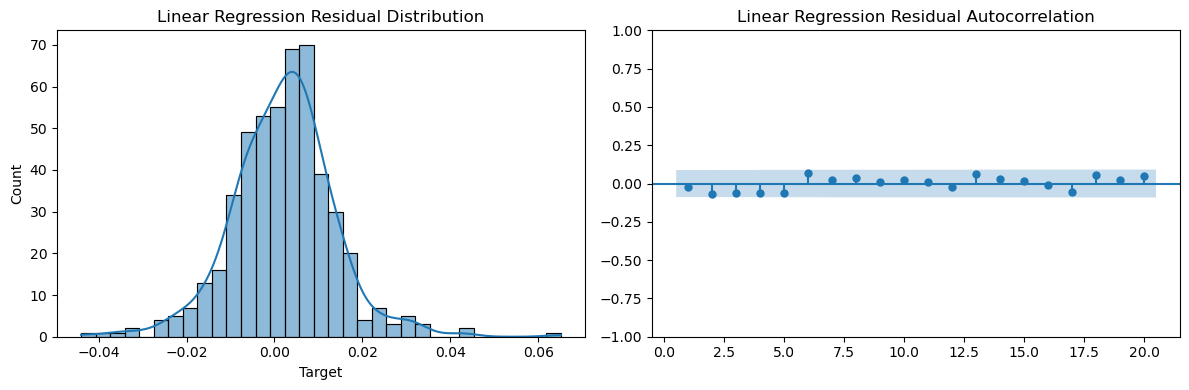

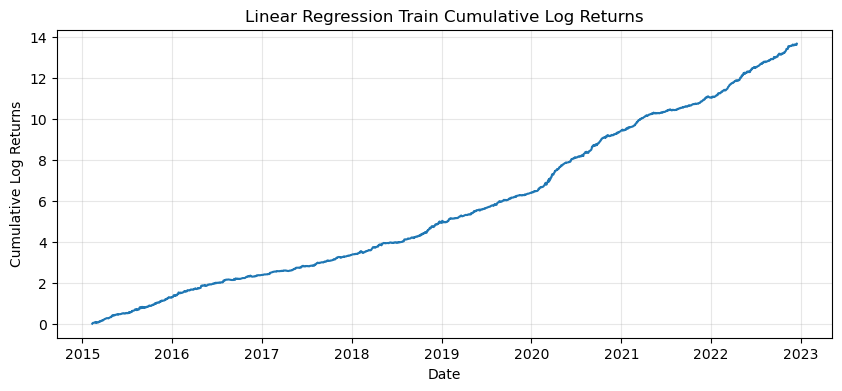

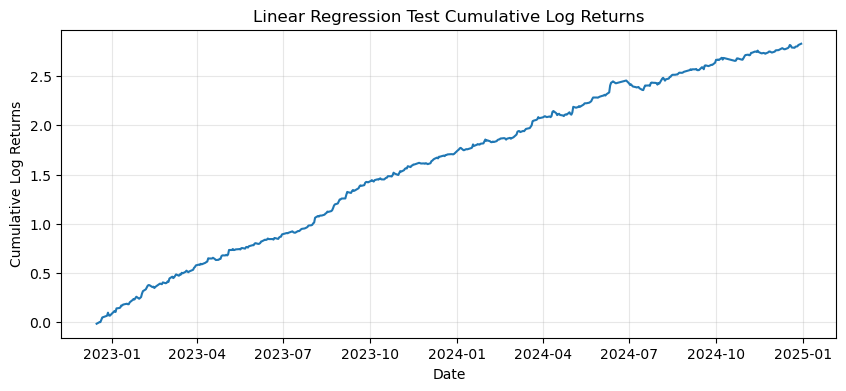

2022-12-16   -0.015
2022-12-19    0.001
2022-12-20    0.002
2022-12-21    0.025
2022-12-22    0.049
              ...  
2024-12-23    2.787
2024-12-24    2.799
2024-12-26    2.802
2024-12-27    2.815
2024-12-30    2.829
Length: 494, dtype: float64

In [317]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# Residuals
residuals_lr = y_test - y_pred_lr

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(residuals_lr, kde=True, ax=axes[0])
axes[0].set_title('Linear Regression Residual Distribution')
plot_acf(residuals_lr, lags=20, zero=False, ax=axes[1])
axes[1].set_title('Linear Regression Residual Autocorrelation')
plt.tight_layout()
plt.show()

# Cumulative returns function
def plot_cumret_log_lr(y_true, y_pred, title):
    # For log returns, cumulative returns = sum of returns
    positions = np.where(y_pred > 0, 1, -1)  # Simple directional strategy
    returns = positions * y_true.values  # Convert to numpy array
    returns = pd.Series(returns, index=y_true.index).fillna(0)
    
    # For log returns: cumulative return = sum of returns
    cumret = returns.cumsum()
    
    plt.figure(figsize=(10,4))
    plt.plot(cumret)
    plt.title(title)
    plt.ylabel('Cumulative Log Returns')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return cumret

# Train cumulative returns
plot_cumret_log_lr(y_train, y_train_pred_lr, 'Linear Regression Train Cumulative Log Returns')

# Test cumulative returns
plot_cumret_log_lr(y_test, y_pred_lr, 'Linear Regression Test Cumulative Log Returns')

## 7.3 SVM 

In [318]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

tscv = TimeSeriesSplit(n_splits=5)
val_scores_svr = []
selected_features_list_svr = []
best_params_list_svr = []

# Stronger regularization for SVR
svr_param = {
    'C': [0.01, 0.1, 1, 10],  
    'epsilon': [0.001, 0.01, 0.1, 0.2],
    'kernel': ['rbf', 'linear']
}

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    selector = SelectKBest(score_func=f_regression, k=5)
    X_train_sel = selector.fit_transform(X_train_fold, y_train_fold)
    X_val_sel = selector.transform(X_val_fold)
    selected_features = X.columns[selector.get_support()]
    selected_features_list_svr.append(selected_features)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_val_scaled = scaler.transform(X_val_sel)

    svr = SVR()
    search = RandomizedSearchCV(svr, svr_param, n_iter=8, cv=3, scoring='neg_mean_squared_error', random_state=42)
    search.fit(X_train_scaled, y_train_fold)
    y_val_pred = search.predict(X_val_scaled)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    r2 = r2_score(y_val_fold, y_val_pred)
    val_scores_svr.append((mse, r2))
    best_params_list_svr.append(search.best_params_)
    print(f"SVR Fold {fold+1}: MSE={mse:.6f}, R2={r2:.4f}, Features={list(selected_features)}, BestParams={search.best_params_}")

val_mse_svr = np.mean([s[0] for s in val_scores_svr])
val_r2_svr = np.mean([s[1] for s in val_scores_svr])
print(f"\nSVR Average Validation MSE: {val_mse_svr:.6f}, R2: {val_r2_svr:.4f}")

SVR Fold 1: MSE=0.000231, R2=-0.4942, Features=['AAPL_Volume', 'SPY_Close', 'VIX_Close', 'RSI', 'DIX_Proxy'], BestParams={'kernel': 'linear', 'epsilon': 0.001, 'C': 1}
SVR Fold 2: MSE=0.000271, R2=0.1141, Features=['AAPL_Close', 'AAPL_Volume', 'VIX_Close', 'RSI', 'DIX_Proxy'], BestParams={'kernel': 'linear', 'epsilon': 0.001, 'C': 0.1}
SVR Fold 3: MSE=0.000779, R2=-0.2253, Features=['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy'], BestParams={'kernel': 'rbf', 'epsilon': 0.001, 'C': 0.1}
SVR Fold 4: MSE=0.000303, R2=0.2243, Features=['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy'], BestParams={'kernel': 'rbf', 'epsilon': 0.001, 'C': 0.1}
SVR Fold 5: MSE=0.000139, R2=0.2200, Features=['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy'], BestParams={'kernel': 'rbf', 'epsilon': 0.001, 'C': 0.1}

SVR Average Validation MSE: 0.000345, R2: -0.0322


In [319]:
# Use the same feature selection for final model
final_selector_svr = SelectKBest(score_func=f_regression, k=5)
X_train_selected_svr = final_selector_svr.fit_transform(X_train, y_train)
X_test_selected_svr = final_selector_svr.transform(X_test)
selected_features_svr = X_train.columns[final_selector_svr.get_support()]

scaler_svr = StandardScaler()
X_train_scaled_svr = scaler_svr.fit_transform(X_train_selected_svr)
X_test_scaled_svr = scaler_svr.transform(X_test_selected_svr)

svr = SVR()
svr_search = RandomizedSearchCV(svr, svr_param, n_iter=8, cv=3, scoring='neg_mean_squared_error', random_state=42)
svr_search.fit(X_train_scaled_svr, y_train)
y_pred_svr = svr_search.predict(X_test_scaled_svr)
y_train_pred_svr = svr_search.predict(X_train_scaled_svr)

print('Selected features for SVR:', list(selected_features_svr))
print('Best SVR params:', svr_search.best_params_)

Selected features for SVR: ['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy']
Best SVR params: {'kernel': 'rbf', 'epsilon': 0.001, 'C': 0.1}


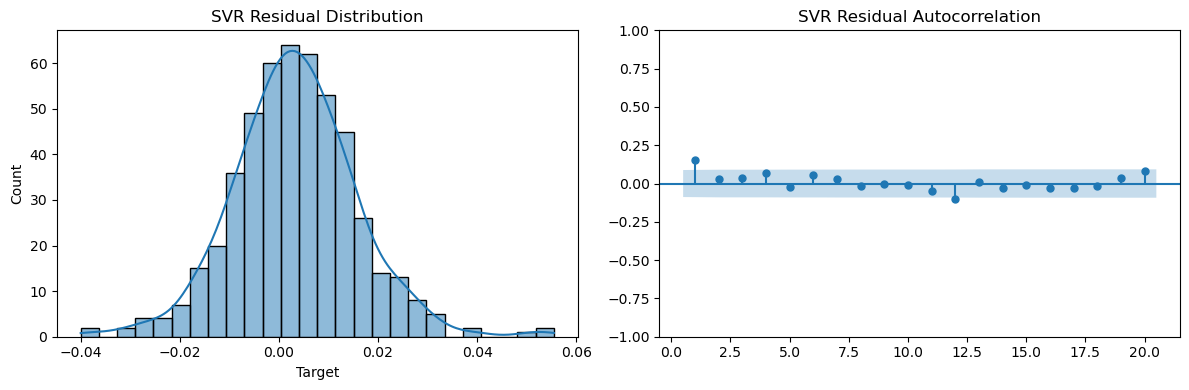

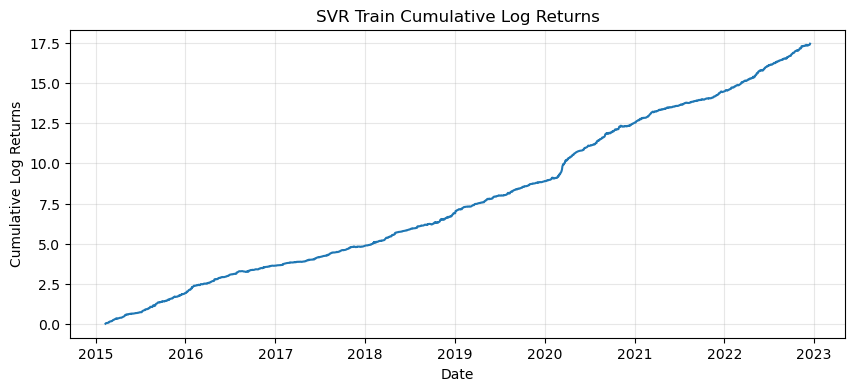

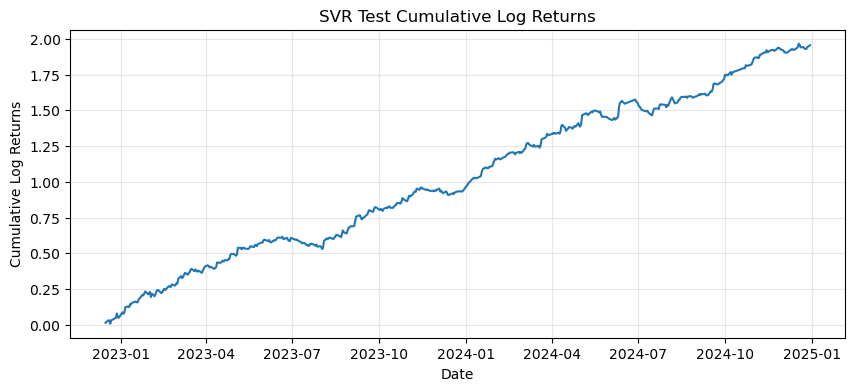

2022-12-16    0.015
2022-12-19    0.031
2022-12-20    0.031
2022-12-21    0.008
2022-12-22    0.032
              ...  
2024-12-23    1.943
2024-12-24    1.931
2024-12-26    1.928
2024-12-27    1.942
2024-12-30    1.955
Length: 494, dtype: float64

In [320]:
# Residuals
residuals_svr = y_test - y_pred_svr

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(residuals_svr, kde=True, ax=axes[0])
axes[0].set_title('SVR Residual Distribution')
plot_acf(residuals_svr, lags=20, zero=False, ax=axes[1])
axes[1].set_title('SVR Residual Autocorrelation')
plt.tight_layout()
plt.show()

# Cumulative returns function
def plot_cumret_log_svr(y_true, y_pred, title):
    # For log returns, cumulative returns = sum of returns
    positions = np.where(y_pred > 0, 1, -1)  # Simple directional strategy
    returns = positions * y_true.values  # Convert to numpy array
    returns = pd.Series(returns, index=y_true.index).fillna(0)
    
    # For log returns: cumulative return = sum of returns
    cumret = returns.cumsum()
    
    plt.figure(figsize=(10,4))
    plt.plot(cumret)
    plt.title(title)
    plt.ylabel('Cumulative Log Returns')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return cumret

# Train cumulative returns
plot_cumret_log_svr(y_train, y_train_pred_svr, 'SVR Train Cumulative Log Returns')

# Test cumulative returns
plot_cumret_log_svr(y_test, y_pred_svr, 'SVR Test Cumulative Log Returns')

## 7.4 XGboost

In [321]:
from xgboost import XGBRegressor

tscv = TimeSeriesSplit(n_splits=5)
val_scores_xgb = []
selected_features_list_xgb = []
best_params_list_xgb = []

# Stronger regularization for XGBoost
xgb_param = {
    'learning_rate': [0.01, 0.05, 0.1],  # Lower learning rates
    'max_depth': [2, 3, 4],  # Reduced max_depth
    'n_estimators': [50, 100],
    'reg_alpha': [0.1, 1, 10],  # L1 regularization
    'reg_lambda': [0.1, 1, 10]  # L2 regularization
}

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    selector = SelectKBest(score_func=f_regression, k=5)
    X_train_sel = selector.fit_transform(X_train_fold, y_train_fold)
    X_val_sel = selector.transform(X_val_fold)
    selected_features = X.columns[selector.get_support()]
    selected_features_list_xgb.append(selected_features)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_val_scaled = scaler.transform(X_val_sel)

    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
    search = RandomizedSearchCV(xgb, xgb_param, n_iter=8, cv=3, scoring='neg_mean_squared_error', random_state=42)
    search.fit(X_train_scaled, y_train_fold)
    y_val_pred = search.predict(X_val_scaled)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    r2 = r2_score(y_val_fold, y_val_pred)
    val_scores_xgb.append((mse, r2))
    best_params_list_xgb.append(search.best_params_)
    print(f"XGBoost Fold {fold+1}: MSE={mse:.6f}, R2={r2:.4f}, Features={list(selected_features)}, BestParams={search.best_params_}")

val_mse_xgb = np.mean([s[0] for s in val_scores_xgb])
val_r2_xgb = np.mean([s[1] for s in val_scores_xgb])
print(f"\nXGBoost Average Validation MSE: {val_mse_xgb:.6f}, R2: {val_r2_xgb:.4f}")

XGBoost Fold 1: MSE=0.000134, R2=0.1348, Features=['AAPL_Volume', 'SPY_Close', 'VIX_Close', 'RSI', 'DIX_Proxy'], BestParams={'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.1}
XGBoost Fold 2: MSE=0.000256, R2=0.1641, Features=['AAPL_Close', 'AAPL_Volume', 'VIX_Close', 'RSI', 'DIX_Proxy'], BestParams={'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.1}
XGBoost Fold 3: MSE=0.000493, R2=0.2239, Features=['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy'], BestParams={'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05}
XGBoost Fold 4: MSE=0.000288, R2=0.2624, Features=['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy'], BestParams={'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.1}
XGBoost Fold 5: MSE=0.000128, R2=0.2784, Features=['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy'], BestParams={'reg_lambda': 

In [322]:
# Use the same feature selection for final model
final_selector_xgb = SelectKBest(score_func=f_regression, k=5)
X_train_selected_xgb = final_selector_xgb.fit_transform(X_train, y_train)
X_test_selected_xgb = final_selector_xgb.transform(X_test)
selected_features_xgb = X_train.columns[final_selector_xgb.get_support()]

scaler_xgb = StandardScaler()
X_train_scaled_xgb = scaler_xgb.fit_transform(X_train_selected_xgb)
X_test_scaled_xgb = scaler_xgb.transform(X_test_selected_xgb)

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_search = RandomizedSearchCV(xgb, xgb_param, n_iter=8, cv=3, scoring='neg_mean_squared_error', random_state=42)
xgb_search.fit(X_train_scaled_xgb, y_train)
y_pred_xgb = xgb_search.predict(X_test_scaled_xgb)
y_train_pred_xgb = xgb_search.predict(X_train_scaled_xgb)

print('Selected features for XGBoost:', list(selected_features_xgb))
print('Best XGBoost params:', xgb_search.best_params_)

Selected features for XGBoost: ['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy']
Best XGBoost params: {'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05}


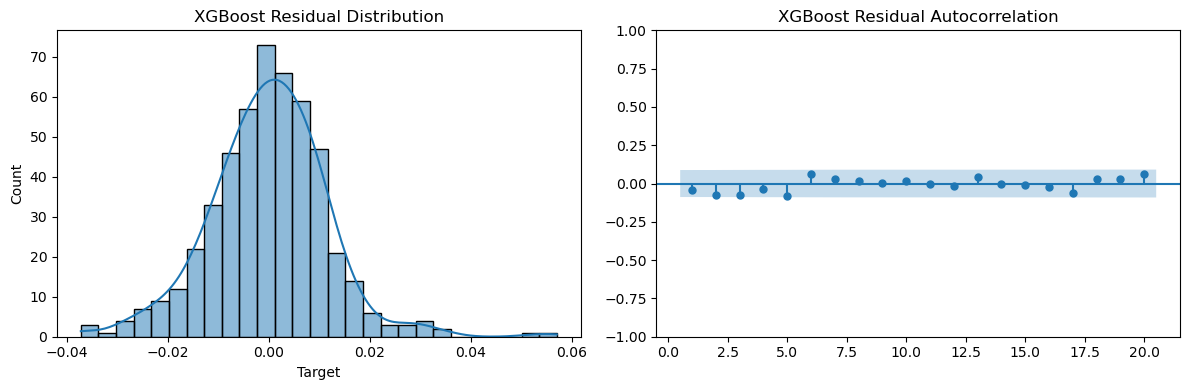

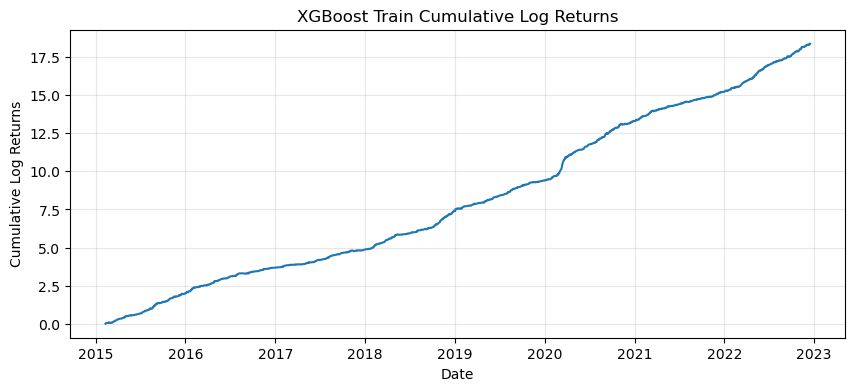

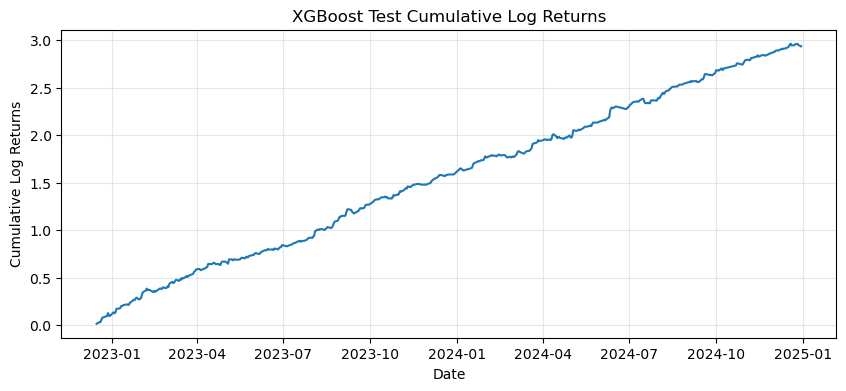

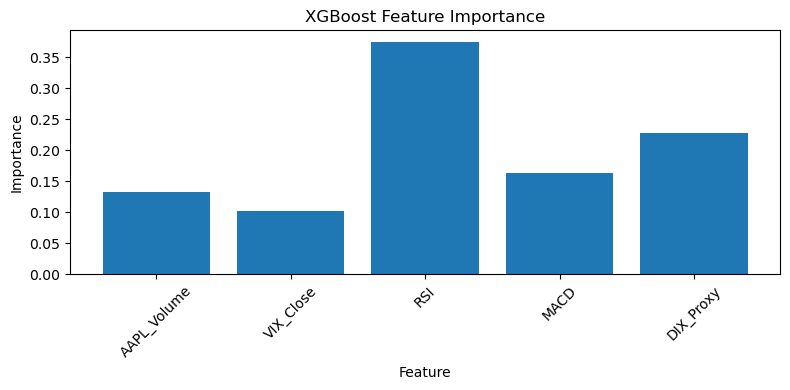

In [323]:
# Residuals
residuals_xgb = y_test - y_pred_xgb

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(residuals_xgb, kde=True, ax=axes[0])
axes[0].set_title('XGBoost Residual Distribution')
plot_acf(residuals_xgb, lags=20, zero=False, ax=axes[1])
axes[1].set_title('XGBoost Residual Autocorrelation')
plt.tight_layout()
plt.show()

# Cumulative returns function
def plot_cumret_log_xgb(y_true, y_pred, title):
    # For log returns, cumulative returns = sum of returns
    positions = np.where(y_pred > 0, 1, -1)  # Simple directional strategy
    returns = positions * y_true.values  # Convert to numpy array
    returns = pd.Series(returns, index=y_true.index).fillna(0)
    
    # For log returns: cumulative return = sum of returns
    cumret = returns.cumsum()
    
    plt.figure(figsize=(10,4))
    plt.plot(cumret)
    plt.title(title)
    plt.ylabel('Cumulative Log Returns')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return cumret

# Train cumulative returns
plot_cumret_log_xgb(y_train, y_train_pred_xgb, 'XGBoost Train Cumulative Log Returns')

# Test cumulative returns
plot_cumret_log_xgb(y_test, y_pred_xgb, 'XGBoost Test Cumulative Log Returns')

# XGBoost Feature Importance
plt.figure(figsize=(8,4))
plt.bar(selected_features_xgb, xgb_search.best_estimator_.feature_importances_)
plt.title('XGBoost Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 8. Evaluation - Plotting and Metrics

In [324]:
# Use the same feature selection for all models
final_selector = SelectKBest(score_func=f_regression, k=5)
X_train_selected = final_selector.fit_transform(X_train, y_train)
X_test_selected = final_selector.transform(X_test)
selected_features = X_train.columns[final_selector.get_support()]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Retrain all models with the same features
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

ridge = Ridge()
ridge.fit(X_train_scaled, y_train)

svr = SVR()
svr_search = RandomizedSearchCV(svr, svr_param, n_iter=8, cv=3, scoring='neg_mean_squared_error', random_state=42)
svr_search.fit(X_train_scaled, y_train)

# Much stronger regularization for XGBoost
xgb_param_strict = {
    'learning_rate': [0.001, 0.01, 0.05],  # Even lower learning rates
    'max_depth': [1, 2, 3],  # Very shallow trees
    'n_estimators': [50, 100],
    'reg_alpha': [1, 10, 100],  # Much stronger L1 regularization
    'reg_lambda': [1, 10, 100],  # Much stronger L2 regularization
    'subsample': [0.5, 0.7, 0.9],  # Add subsampling
    'colsample_bytree': [0.5, 0.7, 0.9]  # Add feature subsampling
}

# Retrain XGBoost with stricter regularization
xgb_strict = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_search_strict = RandomizedSearchCV(xgb_strict, xgb_param_strict, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
xgb_search_strict.fit(X_train_scaled, y_train)

# Calculate predictions
y_pred_lr = lr.predict(X_test_scaled)
y_pred_ridge = ridge.predict(X_test_scaled)
y_pred_svr = svr_search.predict(X_test_scaled)
y_pred_xgb = xgb_search_strict.predict(X_test_scaled)  # Use strict version

y_train_pred_lr = lr.predict(X_train_scaled)
y_train_pred_ridge = ridge.predict(X_train_scaled)
y_train_pred_svr = svr_search.predict(X_train_scaled)
y_train_pred_xgb = xgb_search_strict.predict(X_train_scaled)  # Use strict version

print('Selected features for all models:', list(selected_features))
print('Best SVR params:', svr_search.best_params_)
print('Best XGBoost params (strict):', xgb_search_strict.best_params_)
print('XGBoost Train MSE (strict):', mean_squared_error(y_train, y_train_pred_xgb))
print('XGBoost Test MSE (strict):', mean_squared_error(y_test, y_pred_xgb))

Selected features for all models: ['AAPL_Volume', 'VIX_Close', 'RSI', 'MACD', 'DIX_Proxy']
Best SVR params: {'kernel': 'rbf', 'epsilon': 0.001, 'C': 0.1}
Best XGBoost params (strict): {'subsample': 0.7, 'reg_lambda': 100, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
XGBoost Train MSE (strict): 0.00029260531393469804
XGBoost Test MSE (strict): 0.00015734696589807855


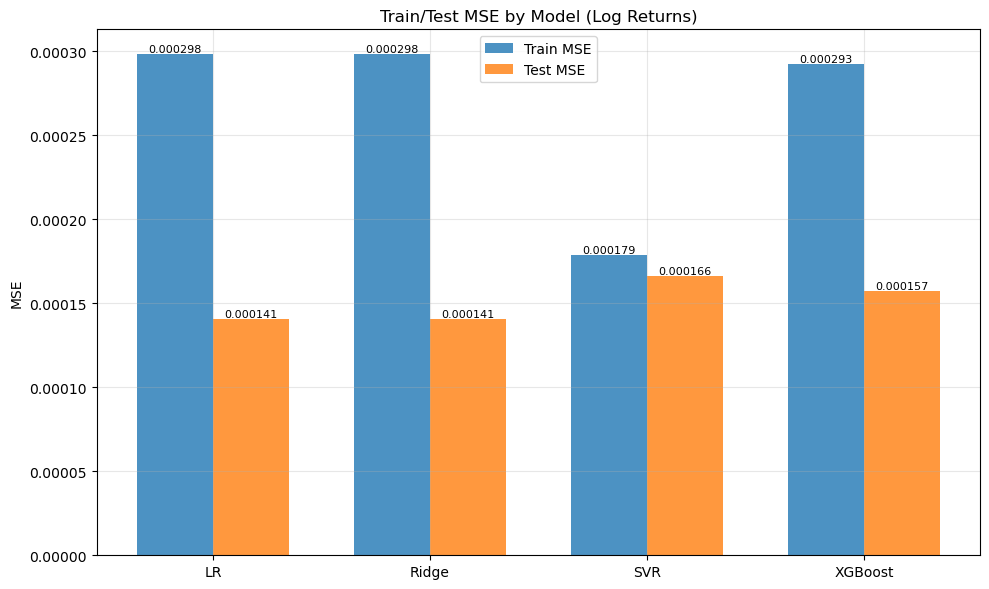

In [325]:
# Calculate train and test MSE for all models
train_mse = [
    mean_squared_error(y_train, y_train_pred_lr),
    mean_squared_error(y_train, y_train_pred_ridge),
    mean_squared_error(y_train, y_train_pred_svr),
    mean_squared_error(y_train, y_train_pred_xgb)
]

test_mse = [
    mean_squared_error(y_test, y_pred_lr),
    mean_squared_error(y_test, y_pred_ridge),
    mean_squared_error(y_test, y_pred_svr),
    mean_squared_error(y_test, y_pred_xgb)
]

labels = ['LR', 'Ridge', 'SVR', 'XGBoost']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, train_mse, width, label='Train MSE', alpha=0.8)
rects2 = ax.bar(x + width/2, test_mse, width, label='Test MSE', alpha=0.8)

ax.set_ylabel('MSE')
ax.set_title('Train/Test MSE by Model (Log Returns)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for i, (train, test) in enumerate(zip(train_mse, test_mse)):
    ax.text(i - width/2, train, f'{train:.6f}', ha='center', va='bottom', fontsize=8)
    ax.text(i + width/2, test, f'{test:.6f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

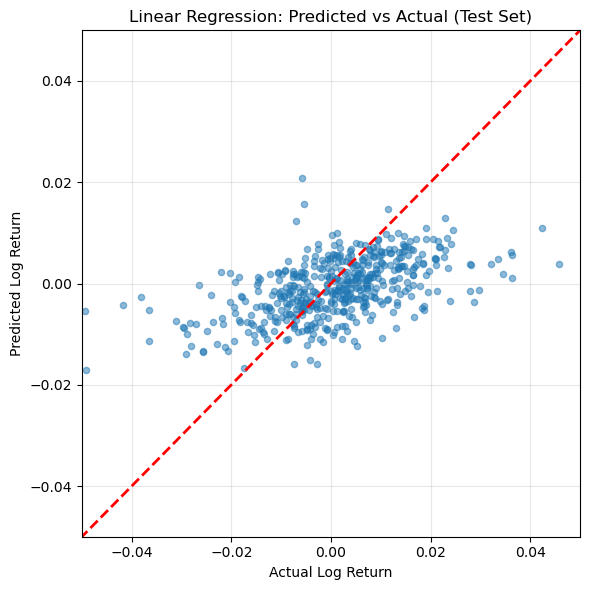

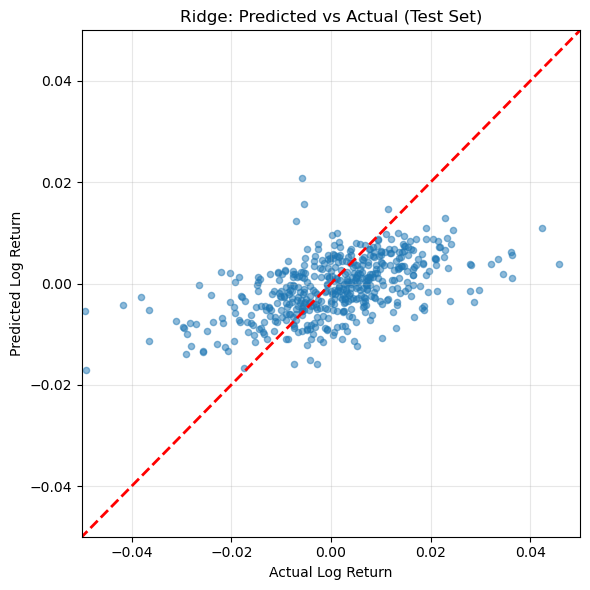

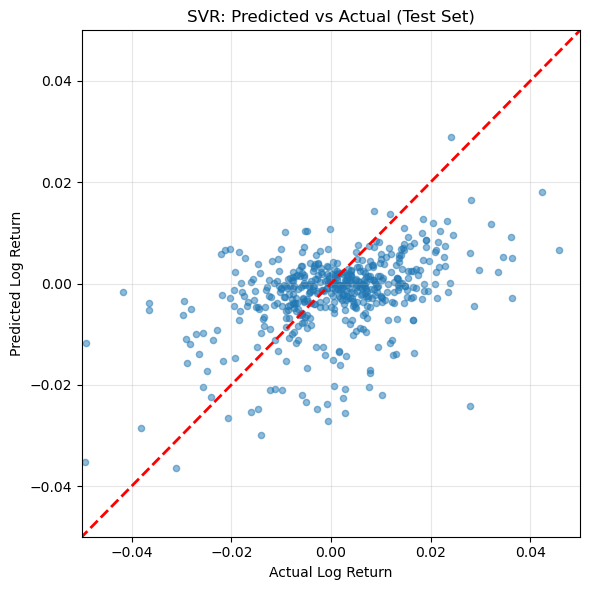

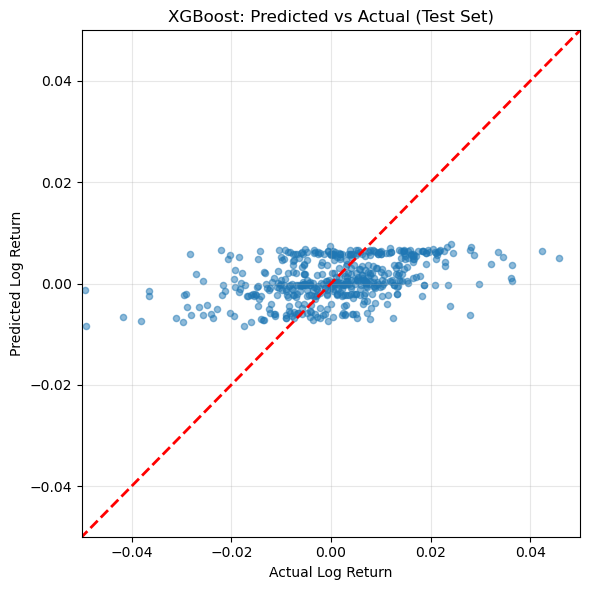

In [326]:
def plot_pred_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5, s=20)
    plt.plot([-0.15, 0.15], [-0.15, 0.15], 'r--', lw=2)
    plt.xlim(-0.05, 0.05)
    plt.ylim(-0.05, 0.05)
    plt.xlabel('Actual Log Return')
    plt.ylabel('Predicted Log Return')
    plt.title(f'{model_name}: Predicted vs Actual (Test Set)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# For all models:
plot_pred_vs_actual(y_test, y_pred_lr, 'Linear Regression')
plot_pred_vs_actual(y_test, y_pred_ridge, 'Ridge')
plot_pred_vs_actual(y_test, y_pred_svr, 'SVR')
plot_pred_vs_actual(y_test, y_pred_xgb, 'XGBoost')

In [327]:
# comprehensive model comparison
print("MODEL PERFORMANCE SUMMARY (Log Returns) ")
print(f"{'Model':<12} {'Train MSE':<12} {'Test MSE':<12} {'Train R2':<12} {'Test R2':<12}")
print("-" * 60)

models = ['LR', 'Ridge', 'SVR', 'XGBoost']
train_preds = [y_train_pred_lr, y_train_pred_ridge, y_train_pred_svr, y_train_pred_xgb]
test_preds = [y_pred_lr, y_pred_ridge, y_pred_svr, y_pred_xgb]

for i, model in enumerate(models):
    train_r2 = r2_score(y_train, train_preds[i])
    test_r2 = r2_score(y_test, test_preds[i])
    print(f"{model:<12} {train_mse[i]:<12.6f} {test_mse[i]:<12.6f} {train_r2:<12.4f} {test_r2:<12.4f}")

MODEL PERFORMANCE SUMMARY (Log Returns) 
Model        Train MSE    Test MSE     Train R2     Test R2     
------------------------------------------------------------
LR           0.000298     0.000141     0.1589       0.2541      
Ridge        0.000298     0.000141     0.1589       0.2541      
SVR          0.000179     0.000166     0.4962       0.1172      
XGBoost      0.000293     0.000157     0.1748       0.1654      


In [328]:
def calculate_financial_metrics(y_true, y_pred, model_name):
    # Calculate positions and returns
    positions = np.where(y_pred > 0, 1, -1)
    returns = positions * y_true.values
    returns = pd.Series(returns, index=y_true.index).fillna(0)
    
    # Financial metrics
    total_return = returns.sum()
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    max_drawdown = (returns.cumsum() - returns.cumsum().expanding().max()).min()
    
    # Profit factor
    profits = returns[returns > 0].sum()
    losses = abs(returns[returns < 0].sum())
    profit_factor = profits / losses if losses > 0 else float('inf')
    
    print(f"{model_name}: Total Return={total_return:.6f}, Sharpe={sharpe_ratio:.4f}, MaxDD={max_drawdown:.6f}, ProfitFactor={profit_factor:.4f}")
    
    return returns

print("FINANCIAL METRICS (Test Set)")
returns_lr = calculate_financial_metrics(y_test, y_pred_lr, "Linear Regression")
returns_ridge = calculate_financial_metrics(y_test, y_pred_ridge, "Ridge")
returns_svr = calculate_financial_metrics(y_test, y_pred_svr, "SVR")
returns_xgb = calculate_financial_metrics(y_test, y_pred_xgb, "XGBoost")

FINANCIAL METRICS (Test Set)
Linear Regression: Total Return=2.828757, Sharpe=7.2396, MaxDD=-0.097175, ProfitFactor=3.5221
Ridge: Total Return=2.842645, Sharpe=7.2826, MaxDD=-0.097175, ProfitFactor=3.5502
SVR: Total Return=1.954920, Sharpe=4.7512, MaxDD=-0.108764, ProfitFactor=2.2543
XGBoost: Total Return=2.581497, Sharpe=6.4946, MaxDD=-0.050047, ProfitFactor=3.0731


In [329]:
# Compare feature importance across models
print("FEATURE IMPORTANCE COMPARISON")
print("Linear Regression coefficients:")
for feat, coef in zip(selected_features, lr.coef_):
    print(f"  {feat}: {coef:.6f}")

print("\nRidge coefficients:")
for feat, coef in zip(selected_features, ridge.coef_):
    print(f"  {feat}: {coef:.6f}")

print("\nXGBoost feature importance:")
for feat, imp in zip(selected_features, xgb_search_strict.best_estimator_.feature_importances_):
    print(f"  {feat}: {imp:.6f}")

FEATURE IMPORTANCE COMPARISON
Linear Regression coefficients:
  AAPL_Volume: -0.000590
  VIX_Close: -0.000093
  RSI: 0.008200
  MACD: -0.004223
  DIX_Proxy: 0.002943

Ridge coefficients:
  AAPL_Volume: -0.000591
  VIX_Close: -0.000095
  RSI: 0.008190
  MACD: -0.004215
  DIX_Proxy: 0.002942

XGBoost feature importance:
  AAPL_Volume: 0.078868
  VIX_Close: 0.051431
  RSI: 0.488318
  MACD: 0.088535
  DIX_Proxy: 0.292848


## 9. WhiteRealityCheck and Monte Carlo

In [330]:
# Export test predictions and returns for  white reality check
y_test.to_csv('y_test_logreturns.csv')
returns_lr.to_csv('returns_lr_logreturns.csv')
returns_ridge.to_csv('returns_ridge_logreturns.csv')
returns_svr.to_csv('returns_svr_logreturns.csv')
returns_xgb.to_csv('returns_xgb_logreturns.csv')


In [331]:
def monte_carlo_permutation_test(model, X_test, y_test, metric_fn=mean_squared_error, n_permutations=1000, random_state=42):
    import numpy as np
    import matplotlib.pyplot as plt

    np.random.seed(random_state)
    original_pred = model.predict(X_test)
    original_score = metric_fn(y_test, original_pred)

    permuted_scores = []
    for _ in range(n_permutations):
        X_permuted = X_test.copy()
        for col in range(X_permuted.shape[1]):
            np.random.shuffle(X_permuted[:, col])
        perm_pred = model.predict(X_permuted)
        perm_score = metric_fn(y_test, perm_pred)
        permuted_scores.append(perm_score)

    permuted_scores = np.array(permuted_scores)
    p_value = np.mean(permuted_scores < original_score)

    print(f"Original Score (MSE): {original_score:.6f}")
    print(f"Permutation p-value: {p_value:.6f}")

    plt.hist(permuted_scores, bins=30, alpha=0.7, label='Permuted Scores')
    plt.axvline(original_score, color='red', linestyle='--', label='Original Score')
    plt.title("Monte Carlo Permutation Test")
    plt.xlabel("MSE")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


Original Score (MSE): 0.000141
Permutation p-value: 0.000000


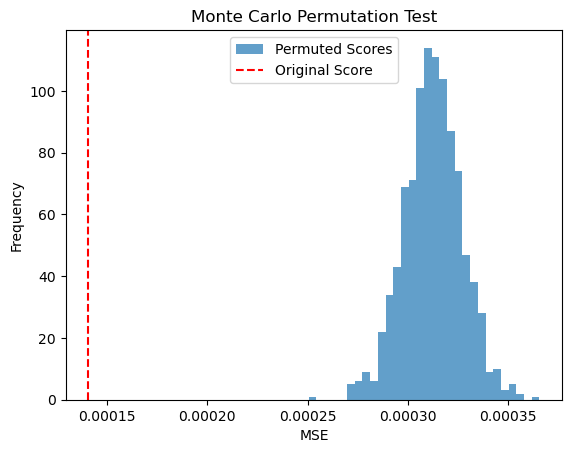

Original Score (MSE): 0.000141
Permutation p-value: 0.000000


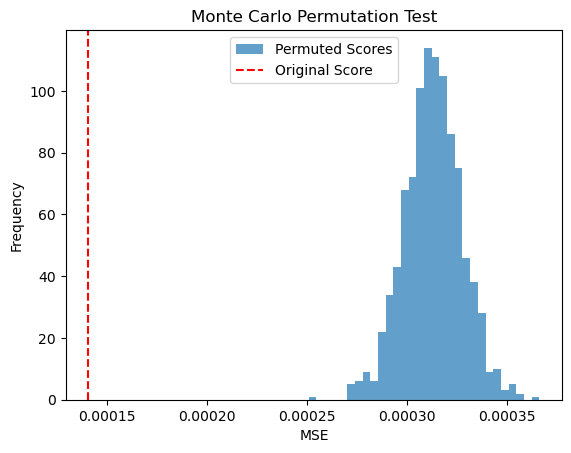

In [332]:
monte_carlo_permutation_test(ridge, X_test_scaled, y_test.values, n_permutations=1000)
monte_carlo_permutation_test(lr, X_test_scaled, y_test.values, n_permutations=1000)

Original Score (MSE): 0.000166
Permutation p-value: 0.000000


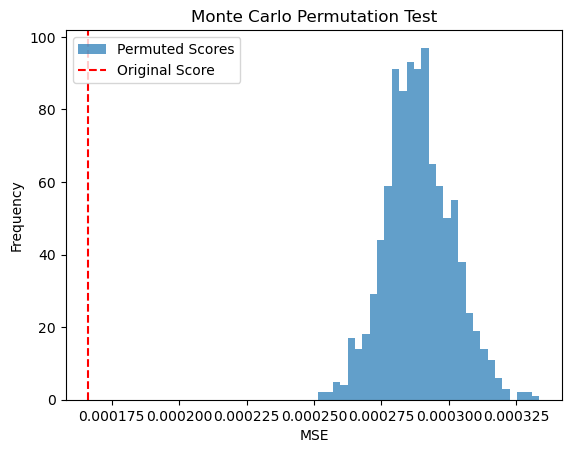

Original Score (MSE): 0.000135
Permutation p-value: 0.000000


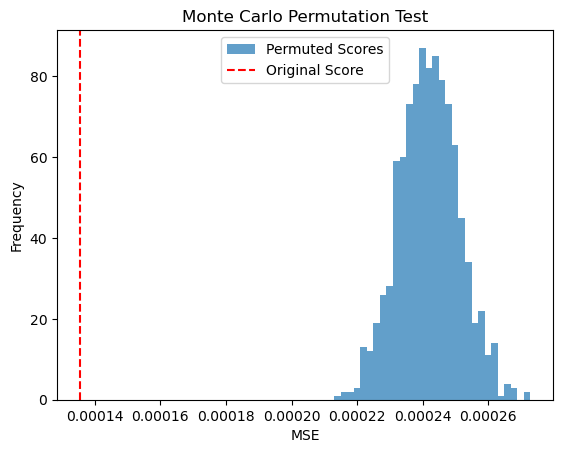

In [334]:
monte_carlo_permutation_test(svr_search.best_estimator_, X_test_scaled, y_test.values)
monte_carlo_permutation_test(xgb_search.best_estimator_, X_test_scaled, y_test.values)
